## msgf+ vs msgf+percolator
Compares number of unique identified peptides for peptide-level q-values from MSGF+ alone and in combination with Percolator

Requires Percolator/qvality installed

Use complete instead of relative path to input files for better compatibilty

In [1]:
%matplotlib inline 
import pandas as pd
import matplotlib.pyplot as plt
import numpy
import matplotlib.patches as mpatches #for the plot legend
import seaborn as sb
import collections #easiest way to sort a dict, see http://stackoverflow.com/questions/9001509/how-can-i-sort-a-dictionary-by-key
import re #regex
import argparse
import os
import csv

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


usage:

##### python msgf+_vs_msgf+percolator.py  [-h]     --csv_file     --target_mzid     --decoy_mzid

(For this notebook, just hard-type the arguments here)

In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("--csv_file", required=True, help="MSGF+ search result in csv format (-tda option in MSGF+ -> TextExporter) without any filtering or processing")
parser.add_argument("--target_mzid", required=True, help="Target mzid file, needed to create percolator input (pin) file")
parser.add_argument("--decoy_mzid", required=True, help="Decoy mzid file, needed to create percolator input (pin) file")
#args = parser.parse_args()
#msgfp_file = args.csv_file
msgfp_file = "/home/vital/cyano_test_dataset/TOPPAS_pipelines/MSGFPlus_percolator/TOPPAS_out/007-TextExporter-out/HF2_20160530_GMFE_Cyano_2ug_3h_vial1_target_decoy.csv"
#target_mzid_file = args.target_mzid
target_mzid_file = "/home/vital/cyano_test_dataset/TOPPAS_pipelines/MSGFPlus_percolator/TOPPAS_out/005-MSGFPlusAdapter-mzid_out/HF2_20160530_GMFE_Cyano_2ug_3h_vial1_target.mzid"
#decoy_mzid_file = args.decoy_mzid
decoy_mzid_file = "/home/vital/cyano_test_dataset/TOPPAS_pipelines/MSGFPlus_percolator/TOPPAS_out/005-MSGFPlusAdapter-mzid_out/HF2_20160530_GMFE_Cyano_2ug_3h_vial1_decoy.mzid"

if not os.path.isfile(msgfp_file):
    print "\nMSGF+ search result file not found: %s " % msgfp_file + "\n"
if not os.path.isfile(target_mzid_file):
    print "\nTarget mzid file not found: %s " % target_mzid_file + "\n"
if not os.path.isfile(decoy_mzid_file):
    print "\Decoy mzid file not found: %s " % decoy_mzid_file + "\n"

#### READ PSMs from MSGFPlus (search with target+decoy, with -tda option)
and discard all but best scoring duplicate PSM matching to one particular peptide (disregarding charge states and PTMs) so I peptide-level q-values can then be estimated with qvality 

In [3]:
msgfp = pd.read_csv(msgfp_file, skiprows=2, delimiter="\t")

#Discard all but best scoring duplicate PSM matching to one particular peptide (disregarding charge states and PTMs)
msgfp_psms = msgfp[msgfp['#PEPTIDE'] == 'PEPTIDE']
msgfp_psms.sequence = msgfp_psms.sequence.str.replace('\(Acetyl\)|\(Oxidation\)|\(Carbamidomethyl\)', '')
msgfp_psms.score = msgfp_psms.score.astype(float) #min and max don't work if score is not float!
#get unique peptide for psm_groups
psm_groups = msgfp_psms.groupby('sequence', group_keys=False)
msgfp_peptides = psm_groups.apply(lambda x: x.ix[x.score.idxmin()])

#Need to provide a null population for qvality
msgfp_null_psms = msgfp_psms[msgfp_psms.accessions.str.contains('XXX') ] #-tda option in MSGF+ adds XXX as decoy label

#Also null PSMs can be assigned to the same decoy sequence!
null_psm_groups = msgfp_null_psms.groupby('sequence', group_keys=False)

#Also get only one, best null psm score, for groups of PSMs referred to the same decoy seq!
msgfp_null_peptides = null_psm_groups.apply(lambda x: x.ix[x.score.idxmin()])

/usr/lib/python2.7/dist-packages/pandas/core/generic.py:2387: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


#### QVality- Estimate pepitde-level q-values for MSGF+ results

In [4]:
msgfp_file_basename = os.path.basename(msgfp_file).split(".")[0]

#qvality requires a file where "each score separated with whitespace or line feed"
msgfp_peptides.score.to_csv("%s_msgfp_peptides_scores.txt"%msgfp_file_basename, index=False)
#and equivalent null_file:
msgfp_null_peptides.score.to_csv("%s_msgfp_null_peptides_scores.txt"%msgfp_file_basename , index=False)

#Run qvality to obtain q-values #NOT  here in notebook! Just in the script!
#qvality_call = "qvality --reverse --output-file" + " %s_qvality_out.csv"%msgfp_file_basename + " %s_msgfp_peptides_scores.txt"%msgfp_file_basename + " %s_msgfp_null_peptides_scores.txt"%msgfp_file_basename
#print("\n\nRunning\n%s\n"%qvality_call+"\n")
#os.system(qvality_call) 

#example of the qvality_call:
#qvality --reverse --output-file 'qvality_out.csv' msgfp_peptides_scores.csv msgfp_null_peptides_scores.csv 
    #target_file and null_file are files containing scores from a mixed model and a null model
    #(--reverse indicates low scores are better, I'm using SpecEvalue.)

#AND  get q-values from msgfp-qvality: #Note I only need the 3rd column, q-value
#msgfp_qvality = pd.read_csv("%s_qvality_out.csv"%msgfp_file_basename, delimiter="\t", usecols=[2])

#NOte: For this notebook, just so I don't have to run qvality here, just hard-type and read :
msgfp_qvality = pd.read_csv("/home/vital/cyano/src/HF2_20160530_GMFE_Cyano_2ug_3h_vial1_target_decoy_qvality_out.csv", delimiter="\t", usecols=[2])


#Output from qvality is sorted by the original score
#So sort my df by score
msgfp_peptides = msgfp_peptides.sort('score')

#And add the q-values from qvality
msgfp_peptides['q-val'] = list(msgfp_qvality['q-value'])

#Filter out decoy hits (If I want to compare with percolator num of proteins, since Perc excludes decoy hits)
msgfp_peptides_excl_decoy = msgfp_peptides[~msgfp_peptides.accessions.str.contains('XXX') ]

#Filter out . q-val <0.01
msgfp_peptides_excl_decoy_001 = msgfp_peptides_excl_decoy[msgfp_peptides_excl_decoy['q-val'] < 0.01 ]

print("Number of unique identified peptides by MSGF+ (excluding decoy hits for q-val 0.01): %s"%len(msgfp_peptides_excl_decoy_001))
print("Number of unique proteins those peptides map to: %s"%len(msgfp_peptides_excl_decoy_001.accessions.unique()))


Number of unique identified peptides by MSGF+ (excluding decoy hits for q-val 0.01): 8237
Number of unique proteins those peptides map to: 1781


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:27: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Percolator input (pin) and output (pout) file names:

In [5]:
pin = "%s.pin"%msgfp_file_basename

pout = "%s_msgfplus_search_percolator_peptides.tsv"%msgfp_file_basename

#### Percolator

In [6]:
#To run Percolator, first create inputfile.pin from a separate target and decoy mzid files:
msgf2pin_call = "msgf2pin -o " + "%s.pin"%msgfp_file_basename + " " + target_mzid_file + " " + decoy_mzid_file

#Don't run msgf2pin here in notebook. Just in the script!
#print("\n\nCreating Percolator input file:\n%s\n"%msgf2pin_call+"\n")
#os.system(msgf2pin_call)

percolator_call = "percolator --results-peptides " + "%s_msgfplus_search_percolator_peptides.tsv"%msgfp_file_basename + " --results-psms " + "%s_msgfplus_search_percolator_psms.tsv"%msgfp_file_basename +  " %s.pin"%msgfp_file_basename

#Don't run Percolator here in notebook. Just in the script!
#print("\n\nRunning Percolator:\n%s\n"%percolator_call+"\n")
#os.system(percolator_call)

Note last column in percolator output (pout) is proteinIds, they should be comma separated but are tab separated
Some peptides are found in several proteins so protein Ids are grouped. 

All these accessions should be together in a group in the last column, but since they are tab separated they appear in successive columns! 

This is bad for reading into a pandas dataframe:

So the pout file requires a little preprocessing here:

Just remove extra proteins/columns for the moment:

In [7]:
#Don't do this here in notebook. Just read trimmed_pout in next step.
#trimmed_pout = "trimmed_" + pout 
#with open(pout,"r") as pi:
#    with open(trimmed_pout,"w") as po:
#        writer=csv.writer(po, delimiter="\t")
#        for row in csv.reader(pi, delimiter="\t"):
#            writer.writerow(row[0:6])

trimmed_pout = "/home/vital/cyano/src/trimmed_HF2_20160530_GMFE_Cyano_2ug_3h_vial1_target_decoy_msgfplus_search_percolator_peptides.tsv"

In [8]:
percolator = pd.read_csv(trimmed_pout, delimiter="\t", skiprows=[1]) #skip row with DefaultDirection

#Remember, to compare with MSGF+ I have to do the same:
#Discard all but best scoring duplicate PSM matching to one particular peptide (disregarding charge states and PTMs)
percolator.peptide = percolator.peptide.str.replace('\[UNIMOD:\d+\]', '')

perc = percolator.groupby('peptide', group_keys=False).apply(lambda p: p.ix[p['q-value'].idxmin()])

perc_f = perc[perc['q-value'] < 0.01]

print("Number of unique identified peptides by MSGF+Percolator (excluding decoy hits for q-val 0.01): %s"%len(perc_f))
print("Number of unique proteins those peptides map to: %s"%len(perc_f.proteinIds.unique()))


Number of unique identified peptides by MSGF+Percolator (excluding decoy hits for q-val 0.01): 8730
Number of unique proteins those peptides map to: 1831


#### Plot unique peptides vs peptide-level q-value

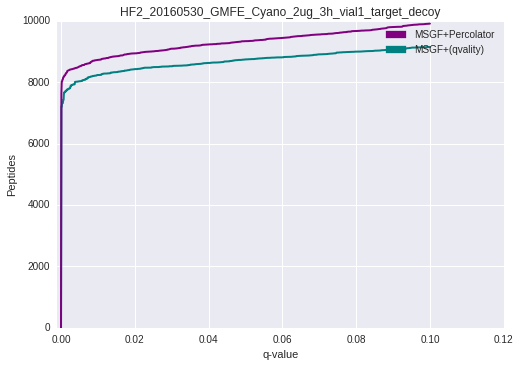

In [9]:
bins = numpy.linspace(0,0.1,1000)

perc_q = {round(i,4): sum(1 for q in list(perc['q-value']) if float(q) < i)  for i in bins}
perc_q = collections.OrderedDict(sorted(perc_q.items()))
#msgfp = collections.OrderedDict(sorted(msgfp.items()))

msgfp_q = {round(i,4): sum(1 for q in list(msgfp_peptides_excl_decoy['q-val']) if float(q) < i)  for i in bins}
msgfp_q = collections.OrderedDict(sorted(msgfp_q.items()))


plt.plot(msgfp_q.keys(), msgfp_q.values(), color='teal', linewidth=2.0)	
plt.plot(perc_q.keys(), perc_q.values(), color='purple', linewidth=2.0)

purple_patch = mpatches.Patch(color='purple', label='MSGF+Percolator')
teal_patch = mpatches.Patch(color='teal', label='MSGF+(qvality)')

plt.xlabel('q-value')
plt.ylabel('Peptides')
plt.title(msgfp_file_basename)
plt.legend(handles=[purple_patch, teal_patch])
plt.xlim(-0.001, )
#plt.ylim(5000, )
plt.show()
